# Mask R-CNN 

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import X_Code.variables as v 

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN/samples/coco/"))  # To find local version
from coco import coco # before: import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "Mask_RCNN\samples\mask_rcnn_coco.h5") # relative path
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config) 

# Load weights trained on MS-COCO
model.load_weights('Mask_RCNN\samples\mask_rcnn_coco.h5', by_name=True) # an additonal model is also present to use (needs relative path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpfow47yrm.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpfow47yrm.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpq40c64ea.py, line 34)
To silence this warning, decorate the function wit

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, t ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.


In [4]:
# Class names

class_names = ['Object' for i in range(90)]

## Run Object Detection

Processing 1 images
image                    shape: (330, 131, 3)         min:   53.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp9tne8wn3.py, line 16)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp9tne8wn3.py, line 16)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co

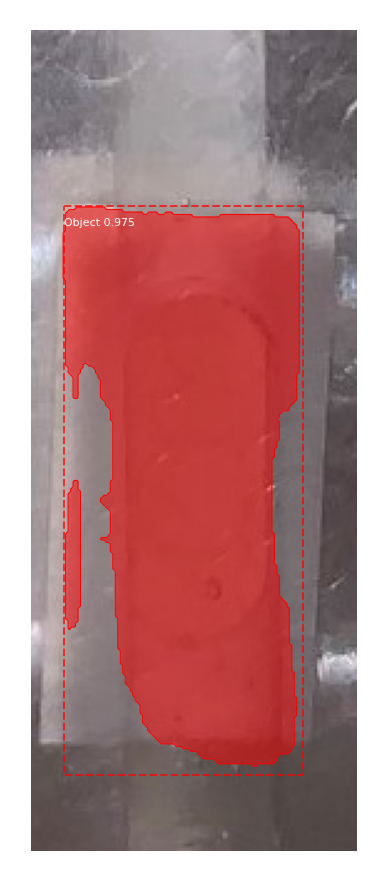

In [5]:
# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, v.path_folder) # relative path

# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

image = skimage.io.imread(v.path_image_abs) # only use absolute path

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

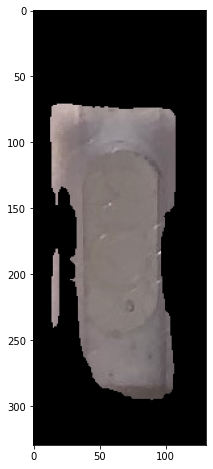

In [6]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

for i in range(mask.shape[2]):
    temp = skimage.io.imread(v.path_image_abs)  # only use absolute path
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)

    image_name = "D:/Christian_Ohlhäuser/Bildauswertung/ColiChecker/images/images_cropped_results/"+v.path_image_abs[72 :] # image name for saving
    plt.savefig(image_name, bbox_inches='tight') # save images for testing, remove later

    plt.show()
    